# DEVOIR FINAL


Import des librairies

In [52]:
%matplotlib inline
import numpy as np
import random
import pandas as pd
from numpy.linalg import svd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.datasets.samples_generator import make_regression
import pylab
from sklearn import datasets
from sklearn import linear_model as lm
from sklearn import svm
import scipy.stats as stats
from numpy import linalg as LA
from numpy.linalg import inv
from numpy.linalg import matrix_rank
from sklearn.preprocessing import StandardScaler
from scipy.stats import t
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

Import des options de graphes:

In [53]:
sns.set_palette("colorblind")
color_blind_list = sns.color_palette("colorblind", 8)
my_orange = color_blind_list[2]
my_green = color_blind_list[1]
my_blue = color_blind_list[0]
my_pink = color_blind_list[3]

## Exercice 1 : Régression robuste

Question 1:   
Soit l'estimateur $\hat{\theta_{\alpha}}= argmin \sum_{i=0}^{n}\rho_{alpha}(y_{i}-\theta_{0}-x^{\top}_{i})$  

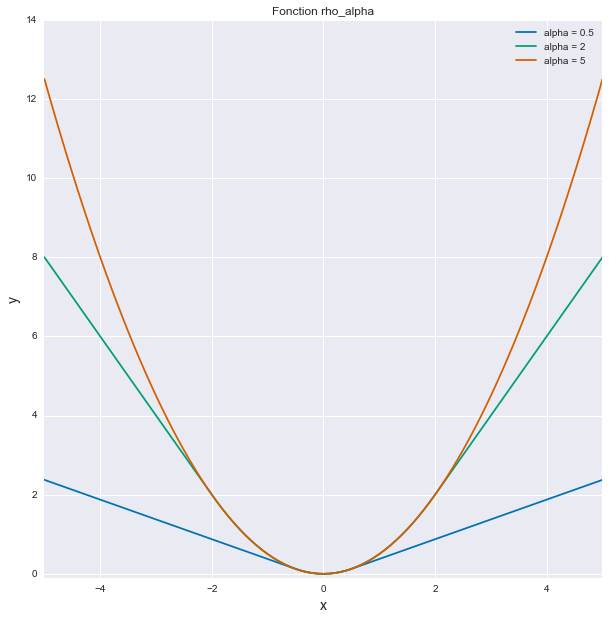

In [54]:
def rho(x, alpha):#on crée une fonction rho dépendant de alpha et x
    if alpha == 0:
        return np.abs(x)

    return np.where(np.abs(x) <= alpha, x ** 2 / 2, alpha * np.abs(x) - (alpha ** 2) / 2)

#on définit les valeurs de alpha qui nous intéressent
alpha1 = 0.5
alpha2 = 2.0
alpha3 = 5.0

#on applique la fonction rho à chaque valeur du vecteur x
x = np.linspace(start=-5, stop=5, num=101)
rho_list1 = []
rho_list2 = []
rho_list3 = []
for i in x:
    rho_temp1 = rho(i, alpha1)
    rho_temp2 = rho(i, alpha2)
    rho_temp3 = rho(i, alpha3)
    rho_list1.append(rho_temp1)
    rho_list2.append(rho_temp2)
    rho_list3.append(rho_temp3)
    
#on trace le graphe
fig0 = plt.figure(figsize=(10, 10))
plt.plot(x, rho_list1,'-', c=my_blue, label='alpha = 0.5')
plt.plot(x, rho_list2,'-', c=my_green, label='alpha = 2')
plt.plot(x, rho_list3,'-', c=my_orange, label='alpha = 5')
plt.xlim(xmin=-5, xmax=5)
plt.ylim(ymin=-0.1, ymax=14)
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.title('Fonction rho_alpha')
plt.legend()
plt.show()

Plus $\alpha$ est grand, plus les pentes des courbes de $\rho_{\alpha}$ sont grandes et par conséquent, la valeur du gradient associée sera plus importante.

Question 2: on génère 100 vecteurs aléatoires $(y_{i},x_{i})$ selon le modèle précédent avec $d=2$, $\theta=(1,1)$ et $\theta_{0}=1$ en supposant le bruit gaussien de moyenne nulle et variance 1.

In [55]:
n = 100
d = 2
theta_0 = np.ones([n])
theta = np.array([1,1])
x = np.random.uniform(low=0, high=1, size=(d,n))
eps = np.random.normal(0, 1.0, n) # loi normale centrée réduite

y = np.dot(x.T, theta) + eps + theta_0

print(y)

[ 3.1138583   2.14911611  2.12170966  2.81682131  2.12019329  1.54620386
  3.53651681  2.70494245  2.15657623  3.22401422  2.38868336  5.33261891
  2.22096725  1.72484205  2.68670379  1.7723054   1.7886892   2.86502726
  1.56715831  1.31137445  0.71186362  1.95001001  4.01553365  2.65233191
  2.28459402  2.36230634  2.77652541  3.18689869  3.04378334  1.24638647
  2.75285338  1.44358979  2.54347841  1.12334947  2.2023449   0.4427031
  2.65010777  1.58361625  2.59743339 -0.44545627  0.59511354  1.13147317
  1.28417007  0.85926935  1.84451836  3.22372247  2.7682522   0.32490717
  1.97152135  2.21840437  3.75761718  1.6982452   0.57339807  1.18277092
  2.65275532  2.39210494  1.24778506  0.02162629  1.22418214  1.97934326
  2.43594312  3.85621239  3.10772269  1.8586927   1.88003847  2.39734887
  0.86971324  2.03405027  3.93795511  2.24361678  2.57754132  2.4489191
 -0.58697538  1.5339282   3.34257926  1.77275767 -0.77444106  3.54077606
  2.05439667  1.47526794  2.20048069  2.39453894  3.1

Question 3 : pour $\alpha = 2$, on cherche à calculer $\hat{\theta_{\alpha}}$, avec la fonction $\mathsf{minimize}$ de $\mathsf{scipy}$.

In [56]:
def theta_hat_alpha(x, y, alpha):
    
    def f_min(theta):
       theta0 = theta[0]
       theta1 = theta[1:]
       diff = y - theta0 - np.dot(x.T, theta1)
       rho_diff = rho(diff, alpha)
       rho_sum = np.sum(rho_diff)
       return rho_sum

    theta_alpha = minimize(f_min, [1,1,1], method="nelder-mead", options={"xtol": 1e-5})
    return theta_alpha["final_simplex"][0][0]

theta_hat = theta_hat_alpha(x, y, alpha2)
print(theta_hat)

[ 1.04160394  0.86056448  1.1568835 ]


Le résultat obtenu est un vecteur theta de 3 composantes telles que theta[0]=$\theta_{0}$ et theta[1:]=$\theta$  
  
Question 4 : on utilise le boostrap des résidus pour calculer l'estimateur bootstrap $\hat{\theta^{\ast}_{\alpha}}$.  
On reprend la méthode précédente mais en introduisant un shuffle dans la génération des résidus.

In [57]:
def theta_hat_star(x, y, alpha):

    def f_min_star(theta):
       theta0 = theta[0]
       theta1 = theta[1:]
       n = len(y)
       diff = y - theta0 - np.dot(x.T, theta1)#résidus
       diff_star = diff[np.random.randint(n, size=n)]#shuffle des residus
       rho_diff_star = rho(diff_star, alpha)
       rho_sum_star = np.sum(rho_diff_star)
       return rho_sum_star

    theta_alpha_star = minimize(f_min_star, [1,1,1], method="nelder-mead", options={"xtol": 1e-5})
    return theta_alpha_star["final_simplex"][0][0]

theta_star= theta_hat_star(x, y, alpha2)
print(theta_star)

[ 1.00120284  0.99842375  1.00147104]


Question 5 : Dans un premier temps on effectue cette fois le bootstrap pour 200 réplicats. On stocke les estimateurs boostrap dans une matrice sur laquelle on va calculer un $\mathsf{np.cov}$

In [58]:
theta_star = np.zeros([3, B])
bias_star = [0,0,0]
err_quad = 0
for b in range(B):
    theta_star[:,b]= theta_hat_star(x, y, alpha2)
    bias_star += (theta_star[:,b]- theta_hat) #calcul du biais
    err_quad += (LA.norm(theta_star[:,b]- theta_hat))**2 #calcul de l'estimateur de l'erreur quadratique
bias_star *= (1/B)
err_quad *= (1/B)
covar_theta_star = np.cov(theta_star)
print(covar_theta_star)

[[ 0.00103435 -0.00032482 -0.00037737]
 [-0.00032482  0.00081014 -0.00018827]
 [-0.00037737 -0.00018827  0.0009781 ]]


La variance est donnée par la diagonale de la matrice covariance.

In [59]:
var_star = np.diag(covar_theta_star)
print(var_star)

[ 0.00103435  0.00081014  0.0009781 ]


On s'intéresse cette fois au biais (on reprend la formule donnée dans le DM 2)

In [60]:
print(bias_star)

[-0.02831707  0.15110848 -0.14349151]


On calcule cette fois l'estimateur de l'erreur quadratique moyenne

In [61]:
print(err_quad)

0.0470339265135


Question 6: On cherche $\alpha$ de façon à minimiser l'erreur quadratique moyenne

l'erreur quadratique minimum est : 0.0486176222559
l'indice correspondant à une erreur quadratique min est: 4
alpha minimisant l'erreur quadratique :  2.0


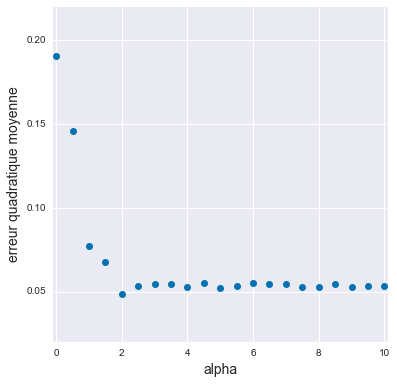

In [63]:
alpha_grid = np.arange(0.0, 10.5, 0.5)
err_quad = []
for al in alpha_grid:
    err_quad_temp = 0
    theta_hat_al = theta_hat_alpha(x, y, al)#on calcule theta_hat (not bootstrap, mais celui de Q3) pour chaque alpha
    for b in range(B):#on fait le bootstrap
        theta_star_temp= theta_hat_star(x, y, al)
        err_quad_temp += (LA.norm(theta_star_temp- theta_hat_al))**2
    err_quad_temp *= (1/B)
    err_quad.append(err_quad_temp)
err_quad = np.array(err_quad)
min_err_quad = min(err_quad)
ind2d = np.argsort(err_quad)
j = ind2d[0]
print('l\'erreur quadratique minimum est :', min_err_quad)
print('l\'indice correspondant à une erreur quadratique min est:', j)
print('alpha minimisant l\'erreur quadratique : ' , alpha_grid[j])
#print( 'alpha minimisant l\'erreur quadratique moyenne:',err_quad.index(min_err_quad))

fig1 = plt.figure(figsize=(6, 6))
plt.plot(alpha_grid, err_quad,'o', c=my_blue)
plt.xlim(xmin=-0.1, xmax=10.1)
plt.ylim(ymin=0.02, ymax=0.22)
plt.xlabel('alpha', fontsize=14)
plt.ylabel('erreur quadratique moyenne', fontsize=14)
plt.show()

Question 7 : on reprend les questions précédentes en utilisant une loi standard de Cauchy pournla distribution des erreurs

l'erreur quadratique minimum pour Cauchy est : 0.368857823746
l'indice correspondant à une erreur quadratique min pour Cauchy est: 6
alpha minimisant l'erreur quadratique pour Cauchy est:  3.0


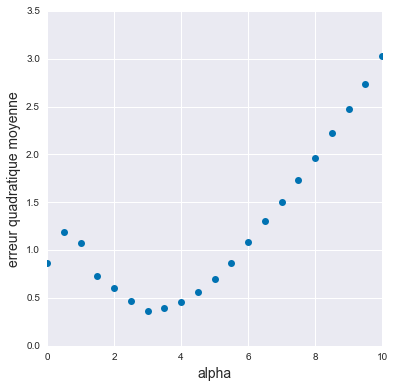

In [65]:
cauchy = np.random.standard_cauchy(100)
y_c = np.dot(x.T, theta) + cauchy + theta_0
alpha_grid = np.arange(0.0, 10.5, 0.5)
err_quad = []
for al in alpha_grid:
    err_quad_temp = 0
    theta_hat_al = theta_hat_alpha(x, y_c, al)#on calcule theta_hat (not bootstrap, mais celui de Q3) pour chaque alpha
    for b in range(B):#on fait le bootstrap
        theta_star_temp= theta_hat_star(x, y_c, al)
        err_quad_temp += (LA.norm(theta_star_temp - theta_hat_al))**2
    err_quad_temp *= (1/B)
    err_quad.append(err_quad_temp)
err_quad = np.array(err_quad)
min_err_quad = min(err_quad)
ind2d = np.argsort(err_quad)
j = ind2d[0]
print('l\'erreur quadratique minimum pour Cauchy est :', min_err_quad)
print('l\'indice correspondant à une erreur quadratique min pour Cauchy est:', j)
print('alpha minimisant l\'erreur quadratique pour Cauchy est: ' , alpha_grid[j])
#print( 'alpha minimisant l\'erreur quadratique moyenne:',err_quad.index(min_err_quad))

fig2 = plt.figure(figsize=(6, 6))
plt.plot(alpha_grid, err_quad,'o', c=my_blue)
plt.xlabel('alpha', fontsize=14)
plt.ylabel('erreur quadratique moyenne', fontsize=14)
plt.show()

On voit que la distribution des erreurs change totalement la valeur $\alpha$ minimisant l'erreur quadratique.  Dans le premier cas l'erreur reste petite $( <0.2)$ alors que dans le second cas, l'erreur augmente de façon drastique avec $\alpha$

## Exercice 2: Ridge, normalisation et validation croisée

Question 1 : On s'intéresse à l'estimateur ridge $\hat{\theta^{rdg}_{\lambda}}$ pour une matrice $X$=$diag(1,-1,1,-1,...,1)$

$$\begin{array}
\hat{\theta^{rdg}_{\lambda}} &= (\lambda .\mathbb{I}_{n} +X^{\top}X)^{-1}X^{\top}y\\
\end{array}
$$  
Sachant que $X^{\top}X$ = $X^{2}$=$\mathbb{I}_{n}$ , on peut remplacer dans l'équation précédente:  
$$\begin{array}
\hat{\theta^{rdg}_{\lambda}} &= \frac{1}{1+\lambda }diag(1,-1,1,-1,...,1)y\\
\end{array}
$$ 

On vérifie numériquement la solution:

In [68]:
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge

n=100
p=100
lambda_r = 2.0
y = np.ones(n)

#on crée la matrice X
vect=[-1 for i in range(n)]
X=np.diag([np.power(vect[i],i) for i in range(n)])

#on calcule numériquement theta_ridge
theta_rdg_num = (1/(1+lambda_r))*np.dot(X.T,y)
print(theta_rdg_num)

[ 0.33333333 -0.33333333  0.33333333 -0.33333333  0.33333333 -0.33333333
  0.33333333 -0.33333333  0.33333333 -0.33333333  0.33333333 -0.33333333
  0.33333333 -0.33333333  0.33333333 -0.33333333  0.33333333 -0.33333333
  0.33333333 -0.33333333  0.33333333 -0.33333333  0.33333333 -0.33333333
  0.33333333 -0.33333333  0.33333333 -0.33333333  0.33333333 -0.33333333
  0.33333333 -0.33333333  0.33333333 -0.33333333  0.33333333 -0.33333333
  0.33333333 -0.33333333  0.33333333 -0.33333333  0.33333333 -0.33333333
  0.33333333 -0.33333333  0.33333333 -0.33333333  0.33333333 -0.33333333
  0.33333333 -0.33333333  0.33333333 -0.33333333  0.33333333 -0.33333333
  0.33333333 -0.33333333  0.33333333 -0.33333333  0.33333333 -0.33333333
  0.33333333 -0.33333333  0.33333333 -0.33333333  0.33333333 -0.33333333
  0.33333333 -0.33333333  0.33333333 -0.33333333  0.33333333 -0.33333333
  0.33333333 -0.33333333  0.33333333 -0.33333333  0.33333333 -0.33333333
  0.33333333 -0.33333333  0.33333333 -0.33333333  0

Question 2: On utilise la fonction ridge de $\mathsf{sklearn}$ pour prédire un vecteur observé $\mathsf{x_{obs}}$ = $(0,1,0,...,0)^{\top}$ avec un vecteur d'entrainement $y=(1,2,3,...,n)^{\top}$ avec $\lambda=12$.  
Remarque: avec un tel vecteur d'entrainement, il ne faut pas s'attendre à un résultat de prédiction franchement excellent...

In [69]:
x_obs = np.zeros(n).reshape(1, -1)
x_obs[0, 1] = 1
y = np.arange(1, n + 1)
ridge = Ridge(alpha=12.0, fit_intercept=False)
ridge.fit(X, y)
pred = ridge.predict(x_obs)
print(pred)#pred est la valeur correspondant à celle non nulle de x_obs

[-0.15384615]


Question 3: Différence entre $\hat{\theta^{rdg}_{\lambda}}$ et $\hat{\theta^{rdgn}_{\lambda}}$  
Dans le cas de $\hat{\theta^{rdgn}_{\lambda}} = arg min_{\theta \in \mathbb{R}^{p}}\frac{1}{2n}\|y-X\theta\|^{2}_{2}+\frac{\lambda}{2}\|\theta\|^{2}_{2}$   
il suffit de faire un changement de variable avec $\lambda^{\prime} = n\lambda$ pour retrouver un ridge classique dont le code se trouve sur $\mathsf{sklearn}$

Question 4 : On génère un jeu de données avec les fonctions suivantes:

In [70]:
def ScenarioEquiCor(n_samples=10, n_features=50, sig_noise=0.1, rho=0.5, s=5, noise_type='Normal'):
    theta = np.zeros((n_features,))
    theta[0:s] = 10 * np.random.rand(s)
    covar = (1 - rho) * np.eye(n_features) + rho * np.ones([n_features, n_features])
    X = np.random.multivariate_normal(np.zeros(n_features,), covar, [n_samples])
    y = AddNoise(np.dot(X, theta), sig_noise)
    return y, theta, X
def AddNoise(vect, sig_noise):
    n_samples = vect.shape[0]
    epsilon = sig_noise * np.random.randn(n_samples,)
    y = vect + epsilon
    return y
n_features = 100
n_samples = 30
n_samples_test = 50
rho = 0.9
sigma = 50
y, theta, X = ScenarioEquiCor(n_samples=n_samples, n_features=n_features, sig_noise=sigma, rho=rho, s=5)
ytest, _, Xtest = ScenarioEquiCor(n_samples=50, n_features=n_features, sig_noise=sigma, rho=rho, s=5)